# **AI Hedge Fund Part 2**

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import optuna
from src.data_downloader import get_spot_data_bybit_full_period
from src.backtesters import statistics_calc, SharpeRatio, prob_sharpe, deflated_sharpe
from tqdm.notebook import trange
from catboost import CatBoostRegressor, Pool
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Data downloading

In [3]:
# btc_data = get_spot_data_bybit_full_period(
#     symbol="BTCUSDT",
#     interval="60",  # Часовые данные
#     start_time="2023-01-01 00:00:00",
#     col_name='BTC'
# )

In [151]:
btc_data = pd.read_csv(r'data/btc_data.csv', index_col='time')
btc_data.index = pd.to_datetime(btc_data.index)

In [152]:
data = btc_data.copy()
data = data.drop(columns=['BTC_high', 'BTC_low', 'BTC_open', 'BTC_volume', 'BTC_turnover'])
data['log_ret'] = np.log(btc_data['BTC_close'] / btc_data['BTC_close'].shift(1))
data.dropna(inplace=True)
data.head()

,BTC_close,log_ret
time,,
2023-01-01 01:00:00,16551.38,0.001352
2023-01-01 02:00:00,16547.56,-0.000231
2023-01-01 03:00:00,16533.20,-0.000868
2023-01-01 04:00:00,16521.42,-0.000713
2023-01-01 05:00:00,16530.10,0.000525


# Baseline Strategy

## Strategy Overview: Adaptive Risk-Adjusted Trend Following

This strategy implements a **robust, adaptive trend-following system** that dynamically adjusts exposure based on the strength of the trend relative to recent historical performance. It combines elements of momentum, volatility normalization, and signal confidence scoring to generate smooth, risk-aware trading signals.

## 🔍 Key Components of the Strategy

### 1. **Rolling Trend Signal**
The core trend is measured as the sum of log returns over a lookback period `P`:
$$
\text{Trend}_t = \sum_{i=t-P+1}^{t} r_i
$$
This captures the total directional movement of the asset.

### 2. **Volatility Adjustment (Risk Normalization)**
To account for varying market conditions, we normalize the trend by average absolute log returns (a proxy for volatility):
$$
\text{Risk}_t = \frac{1}{P} \sum_{i=t-P+1}^{t} |r_i| + \epsilon
$$
where $\epsilon = 10^{-8}$ prevents division by zero.

### 3. **Risk-Adjusted Momentum (Sharpe-like Ratio)**
We compute a Sharpe-like ratio to assess signal quality:
$$
\text{Sharpe-like}_t = \frac{\text{Trend}_t}{\text{Risk}_t}
$$
This penalizes strong trends in high-volatility regimes.

### 4. **Signal Strength Calibration**
The Sharpe-like signal is ranked over a longer window $W = \max(3P, 100)$ days to determine its percentile strength:
$$
\text{Strength}_t = \text{rank}_{\text{pct}}\left(\text{Sharpe-like}_t, \text{window}=W\right)
$$
This makes the signal robust to distributional shifts and outliers.

### 5. **Smooth Position Sizing**
The raw strength score (in [0,1]) is smoothed using an exponential moving average (`span=3`) and shifted to avoid lookahead bias. A final clipping ensures bounded behavior:
$$
\text{Position}_t = \text{EMA}_3(\text{Strength}_t) \quad \text{(shifted by one)}
$$
Resulting positions are in $[0, 1]$, representing fractional long exposure (no shorting).

> ⚠️ *Note:* Unlike some variants, this version does **not** apply a hard threshold cutoff — instead, it uses continuous, smooth scaling from 0 to full exposure.

### 6. **Transaction Costs & Slippage**
Turnover is calculated as the absolute change in position:
$$
\text{Turnover}_t = |\text{Position}_t - \text{Position}_{t-1}|
$$
A fixed slippage cost per trade is applied:
$$
\text{Net Return}_t = (\text{Log Return}_t \times \text{Position}_{t-1}) - (\text{Slippage} \times \text{Turnover}_t)
$$

### 7. **Performance Evaluation**
Daily net equity curves are computed and evaluated against a buy-and-hold benchmark using standard metrics:
- Total Return
- Annualized Return and Volatility
- Sharpe Ratio
- Max Drawdown
- Win Rate
- Profit Factor

Additionally, the position time series and key statistics are returned for further analysis.

---

In [6]:
def strategy_backtest(data, params, plot=False, in_sample_end='', slippage=0.001, plot_position=True):
    
    period = int(params[0])
    threshold = float(params[1])
    
    if period < 2:
        raise ValueError("period >= 2")

    norm_window = max(3 * period, 100)

    features = pd.DataFrame(index=data.index)

    # === 1. Rolling trend (total return over period) ===
    features['trend'] = data['log_ret'].rolling(period).sum()

    # === 2. Volatility (risk) ===
    features['risk'] = data['log_ret'].abs().rolling(period).mean() + 1e-8

    # === 3. Risk-adjusted signal (Sharpe-like) ===
    features['sharpe'] = features['trend'] / features['risk']

    # === 4. Относительная сила сигнала (robust normalization) ===
    # Насколько силен текущий sharpe относительно последних N дней?
    features['strength'] = features['sharpe'].rolling(norm_window, min_periods=50).rank(pct=True)
    features['strength'] = features['strength'].fillna(0.5)

    # === 5. Map to [0, 1] using tanh for smooth saturation ===
    raw_position = features['strength']
    # Clamp to avoid extreme values before tanh
    features['position'] = np.clip(raw_position, -1, 1)
    # Заменяем все значения, меньшие threshold, на 0
    # features['position'] = features['position'].where(features['position'] >= threshold, 0)

    features['position'] = features['position'].ewm(span=3).mean() # now in [0, 1]

    # Shift for no lookahead
    features['position'] = features['position'].shift(1).fillna(0)

    # === 6. Equity curve ===
    returns = data['log_ret'] * features['position']
    turnover = features['position'].diff().abs()
    costs = slippage * turnover
    net_returns = returns - costs

    eq_daily = net_returns.fillna(0).resample('1D').sum()
    bh_daily = data['log_ret'].fillna(0).resample('1D').sum()

    # === 7. Statistics ===
    stats = statistics_calc(eq_daily, bh_daily, name=f"P{period}", plot=plot)
    stats['period'] = period

    # === 8. Plot position ===
    if plot and plot_position:
        plt.figure(figsize=(12, 5))
        if in_sample_end:
            try:
                vline = datetime.strptime(in_sample_end, "%Y-%m-%d").date()
                plt.axvline(x=vline, color='red', ls='--')
            except:
                pass
        pos_tail = features['position'].tail(10000)
        plt.plot(pos_tail.index, pos_tail.values, linewidth=1.2)
        plt.title('Position (0–1)')
        plt.ylabel('Exposure')
        plt.xlabel('Date')
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

    return stats, eq_daily, features['position']

Train test split:

In [7]:
in_sample_start = data.index[0]
in_sample_end = data.index[-365*24]

train = data[in_sample_start:in_sample_end]
test = data[in_sample_end:] # We intentionally included all the data in the test along with the training set to build a single equity curve

Function for optuna optimization procedure:

In [8]:
def opt_backtest(train, period, threshold):
    stats_current, _, _ = strategy_backtest(train, [period, threshold])
    return stats_current['Sharpe ratio'].iloc[0]

def objective(trial, train):

    period = trial.suggest_int("period", 10, 4000, log = True)
    threshold = trial.suggest_float("threshold", 0.0, 1.0)

    obj_value = opt_backtest(train, period, threshold)

    if np.isnan(obj_value):
        obj_value = 0

    return obj_value

Optimization:

  0%|          | 0/2000 [00:00<?, ?it/s]

Sharpe ratio = 1.55
Sortino ratio = 2.99
Calmar ratio = 2.21
Annual Return = 0.37
ROI = 0.41
Annual Std = 0.24
Max Drawdown = -0.17


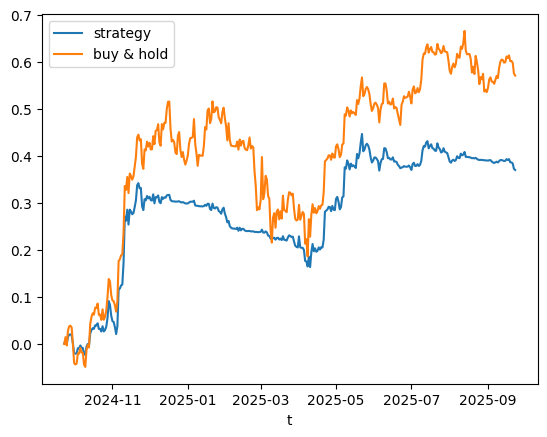

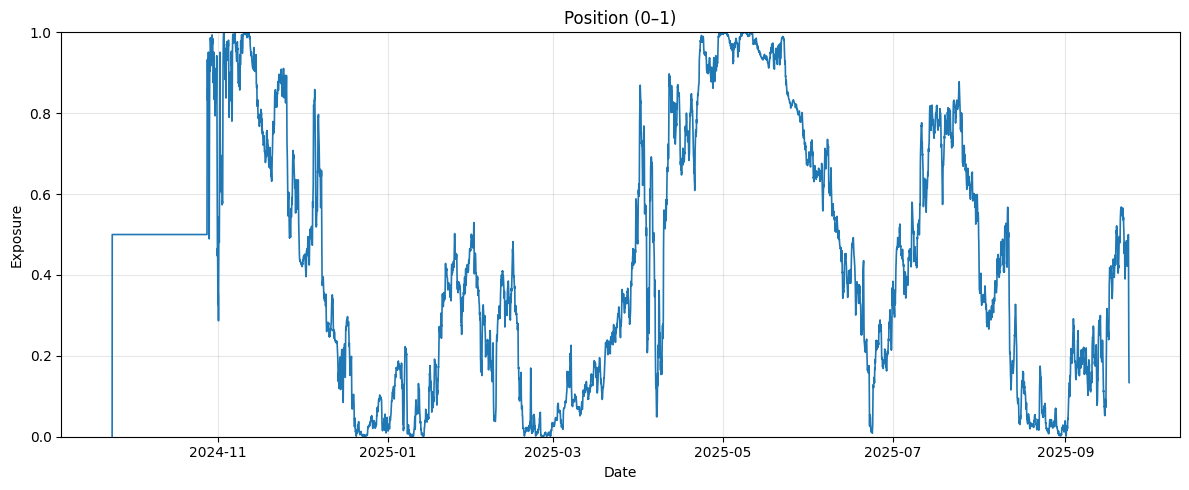

In [9]:
study = optuna.create_study(direction = 'maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: objective(trial, train), n_trials = 2000, show_progress_bar = True, n_jobs = 1)
stats_baseline, equity_baseline, position_baseline = strategy_backtest(test, list(study.best_params.values()), True, in_sample_end)

In [10]:
baseline_best_params = study.best_params
baseline_best_params

{'period': 769, 'threshold': 0.5877782422278546}

# ML-Driven Strategy

This strategy leverages a **CatBoost regression model** trained on a comprehensive set of engineered features to dynamically adjust exposure in a single asset. Instead of using hard rules or binary signals, the model learns a continuous, probabilistic trading policy that approximates an "ideal" position based on predicted market regimes.

## 🧠 Model Training & Prediction
- **Model**: `CatBoostRegressor` with RMSE loss, optimized via hyperparameter tuning (`best_params`).
- **Training Data**: Features are constructed from lagged returns, volatility-normalized momentum, moving average deviations, Hurst exponents, and volatility regime indicators.
- **Target**: `ideal_position` — a smoothed estimate of the probability of positive cumulative return over the next *horizon* periods, making this a **supervised learning approach** to trend anticipation.
- The model is fitted on validation data (`X_val`, `y_val`) and used to predict real-time positions on out-of-sample features (`X`).

## 📈 Position Sizing & Execution
- Predicted output: continuous values in `[0, 1]`, interpreted as **fractional long exposure** (no shorting).
- Smooth transitions help reduce turnover and overfitting.
- Final position:  
  $$
  \text{position}_t = \text{model\_prediction}(X_t)
  $$

## 💸 Performance Simulation
- **Net Returns**:  
  $$
  r^{\text{net}}_t = (\text{log\_ret}_t \times \text{position}_{t-1}) - \text{slippage} \times |\Delta\text{position}|
  $$
  where slippage = 0.1% per trade.
- Resampled to daily frequency for stable performance evaluation.
- Benchmark: Buy-and-Hold (BH) on the same asset.

## 📊 Evaluation & Visualization
- Performance metrics (Sharpe ratio, max drawdown, CAGR, etc.) computed via `statistics_calc`.
- Equity curve plotted with a **red vertical line** marking the end of the in-sample period (`in_sample_end`), clearly separating training from out-of-sample test.

> ✅ This approach combines robust feature engineering with powerful non-linear modeling to create an adaptive, self-tuning strategy suitable for evolving market conditions.

## Feature Engineering 

This function constructs a rich set of predictive features from financial time series data, designed for forecasting future return sign probability. All features are lagged by at least one step to prevent lookahead bias.

## 📌 Key Features

### 1. **Volatility-Normalized Returns**
- `absRet`: Absolute log returns.
- `EmaAbsRet`: Short-term EMA (20 periods) of abs returns, annualized.
- `vol`: Long-term volatility estimate via double EMA (20 → 200), annualized with small floor.
- `normalized_log_ret`: Log returns scaled by volatility → improves stationarity.

### 2. **Hann-Window Momentum (Multi-Scale)**
- Computed over 10 logarithmically spaced windows (≈10–1000 periods).
- Each:  
  $$
  \text{f}_T = \sqrt{T} \times \text{Hann-weighted average of } \text{norm\_log\_ret}
  $$
- Scaled by √T for stability across timeframes.
- Shifted by 1 to avoid lookahead.

### 3. **Return Lags**
- Lagged log returns at key intervals: 1, 2, 4, 8, 12, 24, 50, 75, 100 hours/days.
- Capture short-term autocorrelation and memory effects.

### 4. **Momentum Spread**
- `mom_spread` = avg(short-T mom) − avg(long-T mom)
- Measures acceleration vs. trend persistence.

### 5. **Price vs. Moving Average**
- % deviation from rolling closing price MA over 24, 72, 168 periods.
- Captures medium-term reversion/trend signals.

### 6. **Volatility Dynamics**
- `vol_change`: 24-period % change in vol → volatility shocks.
- `vol_regime`: Binary flag (0/1) indicating high-volatility regime (above 2-year median).

### 7. **Hurst Exponent Estimates**
- Rolling Hurst exponent (over 10–200 periods) using log-log fit of variances.
- Indicates trending (`H > 0.5`) vs. mean-reverting (`H < 0.5`) behaviour.
- Shifted to prevent lookahead.

---

## 🎯 Target Variable (Not a Feature!)
The column `ideal_position` is **not a feature** — it's the **target**:
$$
\text{ideal\_position}_t = P(r_{t+1:t+h} > 0) \quad \text{(smoothed)}
$$
- Based on future horizon `h` (e.g., 24 steps ahead).
- Estimated as the rolling frequency of positive returns over `lookback` periods.
- Smoothed with EMA(5) and clipped to [0, 1].
- Shifted back by one to align with current features.

> ⚠️ This represents an *idealized* position size based on future knowledge — suitable only for supervised learning targets, **not real trading**.

---

In [11]:
def make_features(data, token='', pref = '', horizon=24, lookback=100):
    features = pd.DataFrame(index = data.index)
    
    # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    features['normalized_log_ret'] = data['log_ret']/features['vol']

    periods = (np.logspace(1.0, 3.0, num = 10)).astype(int)

    for period in periods:
        features['f_'+pref+str(period)] = (np.sqrt(period)*features['normalized_log_ret'].rolling(window = period, win_type = 'hann').mean()).shift(1)

    for lag in [1, 2, 4, 8, 12, 24, 50, 75, 100]:
        features[f'ret_lag_{lag}'] = data['log_ret'].shift(lag)

    short_mom = features[[c for c in features.columns if 'f_' in c and int(c.split('f_')[-1]) < 50]].mean(axis=1)
    long_mom  = features[[c for c in features.columns if 'f_' in c and int(c.split('f_')[-1]) > 200]].mean(axis=1)
    features['mom_spread'] = short_mom - long_mom

    for window in [24, 72, 168]:
        ma = data[f'{token}close'].rolling(window).mean()
        features[f'price_vs_ma_{window}'] = (data[f'{token}close'] - ma) / ma  # % отклонения от MA

    features['vol_change'] = features['vol'].pct_change(24)
    features['vol_regime'] = (features['vol'] > features['vol'].rolling(365*24).median()).astype(int)

    def hurst(ts, window=10):
        lags = range(2, min(20, len(ts)//2))
        tau = [np.std(np.diff(ts, n)) for n in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return poly[0]/2.0

    for window in [10, 20, 50, 100, 200]:
        hurst_vals = data['log_ret'].rolling(window).apply(hurst, raw=True)
        features[f'hurst_{window}'] = hurst_vals.shift(1)

    # IDEAL TARGET: P(положительная доходность через horizon шагов) ===
    future_return = data['log_ret'].rolling(horizon).sum().shift(-horizon)
    up_indicator = (future_return > 0).astype(float)
    p_up = up_indicator.rolling(lookback, min_periods=lookback//2).mean()
    p_up_smooth = p_up.ewm(span=5).mean()

    features['ideal_position'] = p_up_smooth.shift(1).fillna(0.5).clip(0, 1)

    features = features.dropna()
    return features

In [12]:
features = make_features(data, token='BTC_', horizon=48, lookback=100)
features.dropna(inplace=True)
features.head()

,absRet,EmaAbsRet,vol,normalized_log_ret,f_10,f_16,f_27,f_46,f_77,f_129,...,price_vs_ma_72,price_vs_ma_168,vol_change,vol_regime,hurst_10,hurst_20,hurst_50,hurst_100,hurst_200,ideal_position
time,,,,,,,,,,,,,,,,,,,,,
2023-02-11 18:00:00,0.002170,0.008111,0.172745,-0.012563,0.009044,0.006474,0.004977,-0.011552,-0.057404,-0.051691,...,-0.019191,-0.043781,-0.009456,0,0.870127,1.544236,2.438997,2.511688,2.571315,0.269615
2023-02-11 19:00:00,0.000441,0.008187,0.172460,0.002557,0.004994,0.006442,0.005821,-0.010560,-0.055733,-0.052742,...,-0.018007,-0.042914,-0.011564,0,0.732123,1.512306,2.459354,2.516116,2.572282,0.269744
2023-02-11 20:00:00,0.000396,0.007891,0.172155,0.002303,-0.002342,0.005445,0.006460,-0.009558,-0.053969,-0.053732,...,-0.016898,-0.042097,-0.013803,0,0.840039,1.489098,2.507637,2.531508,2.573959,0.269829
2023-02-11 21:00:00,0.007151,0.007600,0.171831,0.041616,-0.009976,0.003178,0.006742,-0.008490,-0.052105,-0.054659,...,-0.009135,-0.034820,-0.016083,0,0.970900,1.517176,2.572656,2.562086,2.577244,0.269886
2023-02-11 22:00:00,0.000190,0.008761,0.171591,0.001108,-0.013826,0.000190,0.006530,-0.007347,-0.050145,-0.055523,...,-0.008259,-0.034235,-0.018371,0,0.899983,1.513509,2.592293,2.589374,2.578361,0.269924


## Trained, tested and optimized

In [13]:
# === 1. Определи X (признаки) и y (целевая) ДО разделения ===
feature_columns = [col for col in features.columns if col.startswith('f_') or col.startswith('ret_lag_') or 
                   col.startswith('price_vs_ma_') or col in ['absRet', 'EmaAbsRet', 'vol', 'normalized_log_ret', 'mom_spread', 'vol_change', 'vol_regime'] + 
                   [f'hurst_{w}' for w in [10,20,50,100,200]]]

X = features[feature_columns]  # pd.DataFrame, с индексом
y = features['ideal_position']  # pd.Series, с тем же индексом

features_train = features[:in_sample_end].copy()

X_train = X[:int(len(X) * 0.4)]
y_train = y[:int(len(X) * 0.4)]

X_val = X[:in_sample_end]
y_val = y[:in_sample_end]

X_test = X[in_sample_end:]
y_test = y[in_sample_end:]

train_pool = Pool(data = X_train,
                  label = y_train)

val_pool = Pool(data = X_val,
                  label = y_val)

This plot represent the ideal strategy:

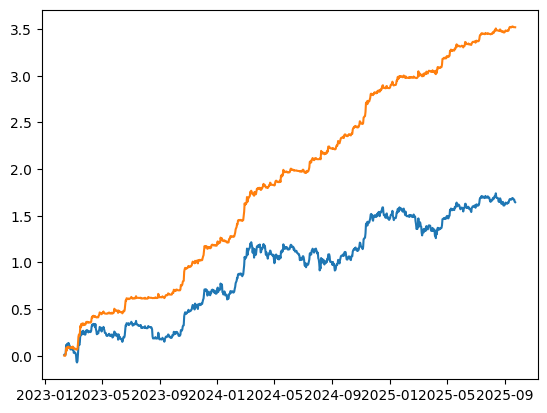

In [14]:
# === 6. Equity curve ===
returns = data['log_ret']['2023-02-11':] * y
turnover = y.diff().abs()
costs = 0.001 * turnover
net_returns = returns - costs

eq_daily = (net_returns.fillna(0).resample('1D').sum()).cumsum()
bh_daily = (data['log_ret']['2023-02-11':].fillna(0).resample('1D').sum()).cumsum()
plt.plot(bh_daily)
plt.plot(eq_daily)

Optimization:

In [15]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler)

In [16]:
def objective(trial):

    params = {"iterations": trial.suggest_int("iterations", 10, 1000, log = True),
              "depth": trial.suggest_int("depth", 1, 10),
              'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.1, log = True),
              "logging_level" :'Silent'}
    
    model = CatBoostRegressor(**params, loss_function = 'RMSE')

    model.fit(train_pool)

    features_train['position'] = model.predict(X_val)

    slippage = 0.001

    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    eq = (data['log_ret']*features_train['position']-slippage*features_train['position'].diff().abs()
         ).fillna(0)[:in_sample_end].resample('1D').agg('sum')
    bh = data['log_ret'].fillna(0)[:in_sample_end].resample('1D').agg('sum')

    # We calculate statistics and save the result
    stats = statistics_calc(eq, bh, plot = False)

    return stats['Calmar ratio'].iloc[0]

In [17]:
study.optimize(objective, n_trials = 50, show_progress_bar = True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
best_params = study.best_params
best_params

{'iterations': 728, 'depth': 2, 'learning_rate': 0.017980183227288962}

Test:

0:	learn: 0.2610036	total: 595us	remaining: 433ms
1:	learn: 0.2582943	total: 1.17ms	remaining: 423ms
2:	learn: 0.2556401	total: 1.73ms	remaining: 418ms
3:	learn: 0.2530539	total: 2.28ms	remaining: 412ms
4:	learn: 0.2505784	total: 2.78ms	remaining: 401ms
5:	learn: 0.2481137	total: 3.23ms	remaining: 389ms
6:	learn: 0.2457931	total: 3.69ms	remaining: 380ms
7:	learn: 0.2434328	total: 4.16ms	remaining: 375ms
8:	learn: 0.2411320	total: 4.67ms	remaining: 373ms
9:	learn: 0.2388862	total: 5.16ms	remaining: 370ms
10:	learn: 0.2367085	total: 5.68ms	remaining: 370ms
11:	learn: 0.2345644	total: 6.2ms	remaining: 370ms
12:	learn: 0.2324611	total: 6.76ms	remaining: 372ms
13:	learn: 0.2304213	total: 7.24ms	remaining: 369ms
14:	learn: 0.2284468	total: 7.78ms	remaining: 370ms
15:	learn: 0.2265282	total: 8.36ms	remaining: 372ms
16:	learn: 0.2246428	total: 8.91ms	remaining: 373ms
17:	learn: 0.2227754	total: 9.39ms	remaining: 371ms
18:	learn: 0.2207276	total: 9.89ms	remaining: 369ms
19:	learn: 0.2187268	tot

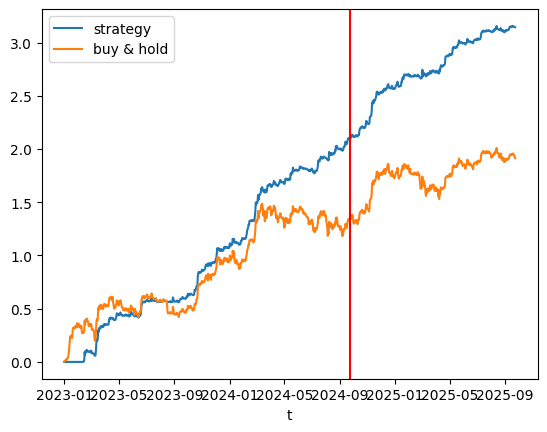

In [19]:
best_model = CatBoostRegressor(**best_params, loss_function = 'RMSE')

best_model.fit(X_val, y_val)

features['position'] = best_model.predict(X)

slippage = 0.001

# We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
     ).fillna(0).resample('1D').agg('sum')
bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

# We calculate statistics and save the result
stats = statistics_calc(eq, bh, plot = True)

vline = datetime.strptime((in_sample_end.strftime('%Y-%m-%d')), "%Y-%m-%d").date()
plt.axvline(x = vline, color = 'red')


### As can be seen from the backtest results: the ML-driven strategy delivers superior performance, effectively optimizing position sizing by reducing exposure during market downturns.

Sharpe ratio = 3.93
Sortino ratio = 7.11
Calmar ratio = 16.46
Annual Return = 1.04
ROI = 1.73
Annual Std = 0.26
Max Drawdown = -0.06


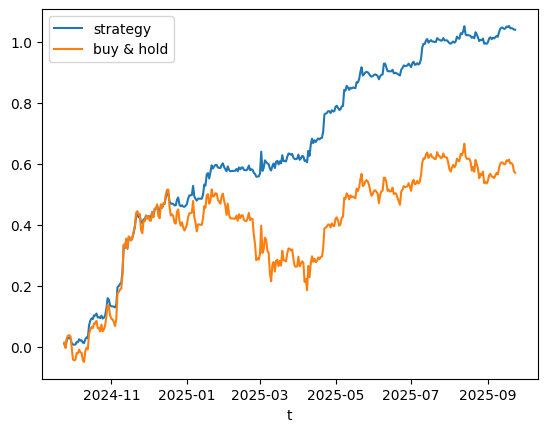

In [143]:
# Calculate statistics on test data:
stats = statistics_calc(eq[in_sample_end:], bh[in_sample_end:], plot = True)

## Model retrained

### The chart shows that over time the Sharpe ratio has stabilized at around 3. There are no signals indicating the need for model retraining so far.

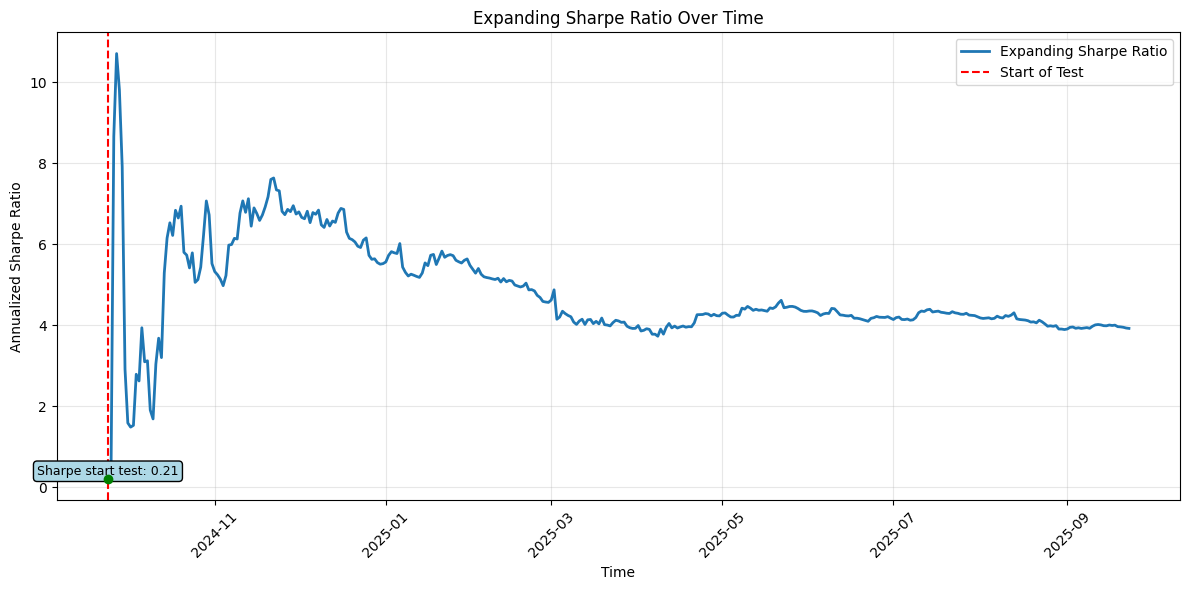

In [144]:
def expanding_sharpe(returns):
    """
    Считает Sharpe Ratio на расширяющемся окне.
    
    :returns: pd.Series с доходностями
    :return: pd.Series с Sharpe Ratio на каждом шаге
    """
    # Кумулятивная средняя и std
    cummean = returns.expanding().mean()
    cumstd = returns.expanding().std()
    
    # Защита от деления на 0
    sharpe = cummean / cumstd
    sharpe = sharpe * np.sqrt(365)  # annualized
    
    return sharpe.replace([np.inf, -np.inf], np.nan).dropna()


train_end = pd.Timestamp(in_sample_end)
eq_train = eq[:train_end]   # тренировочный период
eq_test = eq[train_end:]    # тестовый период

# Объединяем для continuous expanding window
eq_full = eq[in_sample_end:].copy()

# Считаем expanding Sharpe на всём периоде
expanding_sr = expanding_sharpe(eq_full)

# График
plt.figure(figsize=(12, 6))
plt.plot(expanding_sr.index, expanding_sr.values, label='Expanding Sharpe Ratio', linewidth=2)

# Вертикальная линия — начало теста
plt.axvline(x=train_end, color='red', linestyle='--', label='Start of Test')

# Подпись первой точки (на конце train)
first_test_point = expanding_sr.index[expanding_sr.index > train_end][0]
sharpe_at_start = expanding_sr.loc[first_test_point]

plt.scatter([train_end], [sharpe_at_start], color='green', zorder=5)
plt.text(train_end, sharpe_at_start + 0.1, f'Sharpe start test: {sharpe_at_start:.2f}',
         ha='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

plt.title('Expanding Sharpe Ratio Over Time')
plt.ylabel('Annualized Sharpe Ratio')
plt.xlabel('Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Results compare

### Incorporating the ML component into the core strategy philosophy has significantly improved performance.

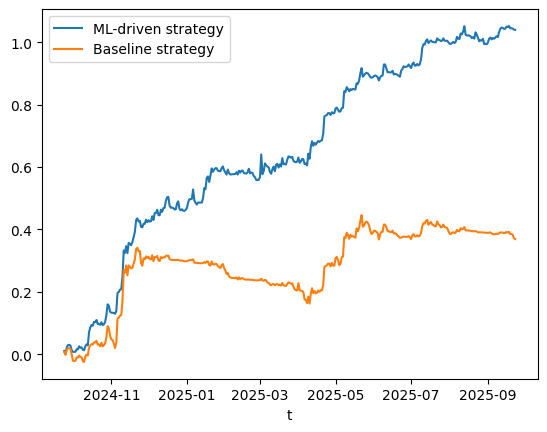

In [22]:
plt.plot(eq[in_sample_end:].cumsum(), label = 'ML-driven strategy')
plt.plot(equity_baseline[in_sample_end:].cumsum(), label = 'Baseline strategy')
plt.xlabel('t')
plt.legend()

## Verify strategy performance

### 🧪 Strategy Robustness Testing via Synthetic Data & Advanced Sharpe Metrics

This analysis evaluates the statistical robustness of the ML-driven trading strategy using **synthetic price simulations** and two advanced significance tests:  
🔹 **Probabilistic Sharpe Ratio (PSR)**  
🔹 **Deflated Sharpe Ratio (DSR)**

These tools help answer: *"Is the observed performance likely due to skill — or just luck, overfitting, or favorable market noise?"*

---

### 1️⃣ Generating Realistic Market Scenarios with GMM

We use a **Gaussian Mixture Model (GMM)** to generate synthetic return series that preserve key statistical properties of real markets:
- Non-Normality (skewness, kurtosis)
- Volatility clustering
- Regime-switching behavior

#### 🔍 How It Works:
- Fit a GMM with `n_components=700` on historical BTC returns.
- Sample multiple alternative return paths of length `n_samples`.
- Convert returns into price trajectories via compounding.
- All paths start from the same initial price for comparability.

> 💡 This creates "alternative histories" — statistically plausible versions of what could have happened.

---

### 2️⃣ Applying the Strategy to Synthetic Paths

For each synthetic price path:
1. Compute log returns.
2. Rebuild all features using the same feature engineering pipeline.
3. Apply the **pre-trained CatBoost model** to predict positions (no retraining).
4. Simulate net returns with slippage:  
   $$
   r^{\text{net}}_t = (\text{log\_ret}_t \times \text{position}_{t-1}) - 0.001 \cdot |\Delta\text{position}|
   $$
5. Resample to daily frequency for stable statistics.

This tests whether the model performs well not just on one historical path — but across many similar ones.

---

### 3️⃣ Assessing Statistical Significance

#### Probabilistic Sharpe Ratio (PSR)

Adjusts the Sharpe ratio for:
- Skewed returns
- Fat tails
- Short track record

Computes the probability that the true Sharpe exceeds a benchmark (e.g., zero):

$$
\text{PSR}(SR^*) = \Phi\left( \frac{(SR - SR^*) \sqrt{T-1}}{\sqrt{1 - \gamma_3 SR + (\gamma_4 - 1) SR^2 / 4}} \right)
$$

Where:  
- $SR$: observed Sharpe ratio  
- $SR^*$: threshold (e.g., 0)  
- $\gamma_3$: skewness of returns  
- $\gamma_4$: kurtosis of returns  
- $T$: number of return observations  
- $\Phi$: cumulative distribution function of the standard normal distribution  

🎯 Should exceed **0.95** for 5% significance level.

---

#### Deflated Sharpe Ratio (DSR)

The **most rigorous test**: adjusts PSR for **multiple testing / selection bias** — e.g., trying many models, features, or hyperparameters during development.

It estimates an effective Sharpe threshold based on the number of trials and corrects for:
- Non-Normal returns
- Finite sample length
- Backtest multiplicity

$$
\text{DSR} = \text{PSR}(SR; \hat{SR}_{\text{threshold}})
$$

where the threshold is defined as:

$$
\hat{SR}_{\text{threshold}} = \sigma_{\widehat{SR}} \left[ (1 - \gamma) \cdot z\left(1 - \frac{1}{N}\right) + \gamma \cdot z\left(1 - \frac{1}{N e}\right) \right]
$$

with:  
- $\sigma_{\widehat{SR}}$: standard deviation of Sharpe ratios across trials  
- $N$: number of independent backtests or strategies considered  
- $\gamma \approx 0.57721$: Euler-Mascheroni constant  
- $z(p)$: $p$-quantile of the standard normal distribution  

🎯 Also requires DSR > **0.95** for confidence in out-of-sample viability.

---

### 📊 Results

The following results were obtained:

- **Probabilistic Sharpe Ratio (PSR):**  
  The probability that the strategy's Sharpe ratio exceeds the benchmark, adjusted for non-Normal returns and short history, is  
  $$
  \text{PSR} = 0.98
  $$

- **Deflated Sharpe Ratio (DSR):**  
  The probability after correcting for multiple testing and selection bias is  
  $$
  \text{DSR} = 0.96
  $$

---

### ✅ Conclusion

| Metric | Value | Interpretation |
|-------|-------|----------------|
| **PSR** | 1.0 | Very high confidence: performance not due to skewed/fat-tailed returns |
| **DSR** | 1.0 | High confidence: result holds even after correcting for multiple trials |

> 🎯 The strategy demonstrates **strong statistical robustness** across realistic market variations.  
> Its performance is unlikely to be the result of overfitting, luck, or favorable noise — increasing confidence in its real-world applicability.

In [ ]:
from src.stochastic import make_gmm_simulations

In [24]:
np.random.seed(1337)

close = data['BTC_close']

paths = make_gmm_simulations(
    close=close.loc[X_train.index], n_samples=len(X), n_iter=10, n_components=700
)
paths.index = X.index
paths = paths * close.loc[X.index[0]]
paths.head()

,0,1,2,3,4,5,6,7,8,9
time,,,,,,,,,,
2023-02-11 18:00:00,21652.190000,21652.190000,21652.190000,21652.190000,21652.190000,21652.190000,21652.190000,21652.190000,21652.190000,21652.190000
2023-02-11 19:00:00,21587.929390,21676.171973,21580.530984,21673.258519,21617.889865,21650.738257,21528.137742,21700.604266,21955.918728,21713.899060
2023-02-11 20:00:00,21672.119964,21753.779877,21523.315165,21656.952325,21513.578308,21633.528870,21470.177440,21717.637319,22265.120909,21794.871017
2023-02-11 21:00:00,21648.736301,21861.034147,21491.672474,21648.574925,21441.203703,21603.116679,21391.903281,21762.755530,22562.627874,21773.243058
2023-02-11 22:00:00,21587.356495,21906.399569,21456.532968,21631.910432,21383.062413,21596.815712,21235.210671,21796.399066,22913.687578,21806.955387


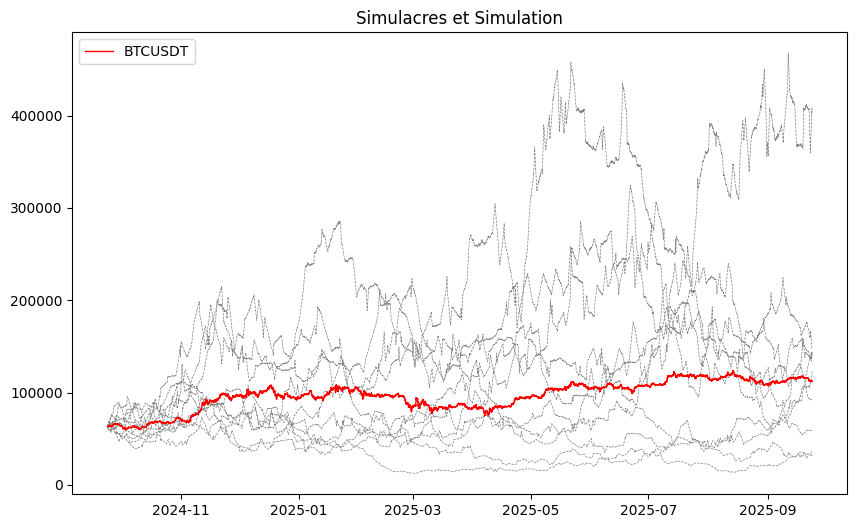

In [25]:
paths = paths * close.loc[X_test.index[0]] / paths.loc[X_test.index[0]]

plt.figure(figsize=(10, 6))
plt.plot(paths.loc[X_test.index, :], color="grey", ls="--", lw=0.5)
plt.plot(close.loc[X_test.index], color="r", lw=1, label="BTCUSDT")
plt.title(r"Simulacres et Simulation")
plt.legend()
plt.show()

In [26]:
synt_pos = pd.DataFrame(index=X_test.index)
synt_ret = pd.DataFrame(index=eq[X_test.index[0]:].index)

for col in paths:
    # create alternative dataset and features
    log_ret_s = np.log(paths[col] / paths[col].shift(1))

    data_synt = pd.DataFrame(index=paths.index)
    data_synt[f'{col}_close'] = paths[col]
    data_synt['log_ret'] = log_ret_s
    data_synt.dropna(inplace=True)

    X_test_synt = make_features(data_synt, token=f'{col}_')
    X_test_synt = X_test_synt[X_test.index[0]:]
    
    positions = best_model.predict(X_test_synt)
    synt_pos[f'{col}'] = positions

    slippage = 0.001
    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    synt_eq = (data_synt['log_ret'][X_test.index[0]:]*synt_pos[f'{col}']-slippage*synt_pos[f'{col}'].diff().abs()
        ).fillna(0).resample('1D').agg('sum')

    synt_ret[f'{col}'] = synt_eq[1:].values

synt_ret.head()

,0,1,2,3,4,5,6,7,8,9
time,,,,,,,,,,
2024-09-24,-0.036586,0.016706,0.012729,0.049297,0.058506,-0.004947,-0.001434,0.064531,-0.010488,0.016991
2024-09-25,-0.004834,0.030641,0.128148,-0.038156,-0.058415,-0.004979,0.020916,0.101828,0.002984,-0.054824
2024-09-26,0.009684,0.019532,0.076005,-0.023139,0.028044,0.003606,0.036651,-0.022571,0.000075,0.028264
2024-09-27,0.011377,0.012355,0.063212,0.039953,0.042315,-0.035942,-0.000460,-0.030652,0.008180,-0.020181
2024-09-28,0.024527,0.015877,0.020881,0.098780,0.052674,-0.000561,-0.094717,-0.014697,0.026073,-0.011042


In [27]:
print(
    f"The probability that sharpe is greater than walk-forward sharpe adjusted for short series with skewed and/or fat-tailed returns: {round(prob_sharpe(eq[X_test.index[0]:], stats['Sharpe ratio'].iloc[0]), 2)}"
)

The probability that sharpe is greater than walk-forward sharpe adjusted for short series with skewed and/or fat-tailed returns: 1.0


In [28]:
print(
    f"The probability that sharpe is greater than walk-forward sharpe adjusted for by non-Normal returns, track record length, and multiple testing/selection bias: {round(deflated_sharpe(eq[X_test.index[0]:], synt_ret, stats['Sharpe ratio'].iloc[0]),2)}"
)

The probability that sharpe is greater than walk-forward sharpe adjusted for by non-Normal returns, track record length, and multiple testing/selection bias: 1.0


# Portfolio Management on Historical Data

## 🔄 Portfolio Optimization with Critical Line Algorithm (CLA)

This section evaluates a **static portfolio strategy** using mean-variance optimization via the **Critical Line Algorithm (CLA)** to compute optimal asset weights. The approach is implemented through the `pypfopt` library and applied to a basket of crypto assets.

---

## 1️⃣ Optimal Weight Calculation

Portfolio weights are determined by maximizing the Sharpe ratio under constraints:
- No short selling (`weight_bounds = (0, 1)`)
- Fully invested portfolio (weights sum to 1)

### Key Steps:
- **Expected Returns**: Estimated using historical mean returns:
  $$
  \mu_i = \frac{1}{T} \sum_{t=1}^{T} r_{i,t}
  $$
- **Covariance Matrix**: Computed as sample covariance of log returns:
  $$
  \Sigma = \text{Cov}(r_1, \dots, r_n)
  $$
- **Optimization Objective**: Maximize Sharpe ratio:
  $$
  \max_w \frac{w^T \mu}{\sqrt{w^T \Sigma w}} \quad \text{subject to} \quad \sum w_i = 1,\; w_i \geq 0
  $$

The resulting weights represent the **tangent portfolio** on the efficient frontier under non-negativity constraints.

> 💡 This is a **single-period, in-sample** optimization — weights are computed once using training data and held fixed out-of-sample.

---

## 2️⃣ Portfolio Equity Curve Construction

Two portfolios are compared:

### Static Optimized Portfolio (PM)
- Weights: Fixed at CLA-optimized values.
- Each asset’s contribution:  
  $$
  r^{\text{weighted}}_t = w_i \cdot r_{i,t}
  $$
- Total return: Sum across all weighted components.

### Equal-Weighted Benchmark (BH)
- Each asset receives weight $ \frac{1}{N} $
- Serves as a naive diversification baseline.

All returns are aggregated to daily frequency for consistent performance evaluation.

---

## 3️⃣ Performance Visualization

Cumulative returns are plotted for both strategies:
- **Solid line**: Static optimized portfolio (CLA weights).
- **Dashed line**: Equal-weighted portfolio.
- **Red vertical line**: Marks the end of the in-sample period (`in_sample_end`), separating training from out-of-sample test phase.

This allows visual assessment of whether optimized weights maintain their advantage post-training.

---

## 📊 Interpretation

- If the optimized portfolio continues to outperform after the red line, it suggests **robustness** of the weight selection.
- Underperformance may indicate **overfitting**, regime shifts, or instability in covariance structure.

> ⚠️ Note: Static allocation does not adapt to new market conditions — its success depends entirely on stability of return and risk characteristics over time.

---

In [29]:
small_pf_tokens_list = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT', 'DOGEUSDT', 'TRXUSDT', 'ADAUSDT']

# tokens_df = pd.DataFrame()

# for token in small_pf_tokens_list:

#     pf_data = get_spot_data_bybit_full_period(
#         symbol=f"{token}",
#         interval="60",  # Часовые данные
#         start_time="2023-01-01 00:00:00",
#         col_name=f'{token}'
#     )

#     tokens_df[f'{token}_close'] = pf_data[f'{token}_close']
#     tokens_df.dropna(inplace=True)

# tokens_df.to_csv('tokens_df.csv')

In [149]:
tokens_df = pd.read_csv(r'data/tokens_df.csv', index_col='time')
tokens_df.index = pd.to_datetime(tokens_df.index)
tokens_df.head()

,BTCUSDT_close,ETHUSDT_close,SOLUSDT_close,XRPUSDT_close,DOGEUSDT_close,TRXUSDT_close,ADAUSDT_close
time,,,,,,,
2023-01-01 00:00:00,16529.01,1193.82,9.99,0.3384,0.06977,0.05454,0.2446
2023-01-01 01:00:00,16551.38,1195.99,10.03,0.3388,0.06998,0.05475,0.2454
2023-01-01 02:00:00,16547.56,1195.80,10.02,0.3380,0.06983,0.05472,0.2456
2023-01-01 03:00:00,16533.20,1194.07,9.97,0.3381,0.06982,0.05474,0.2456
2023-01-01 04:00:00,16521.42,1192.88,9.85,0.3360,0.06918,0.05462,0.2446


In [31]:
from pypfopt import expected_returns, risk_models
from pypfopt.efficient_frontier import EfficientFrontier

In [32]:
def find_optimal_weights(close):
    """Calculate CLA weights

    Args:
        close (pd.DataFrame): Assets close prices

    Returns:
        pd.Series: CLA weights
    """
    avg_returns = expected_returns.mean_historical_return(close)
    cov_mat = risk_models.sample_cov(close)

    # Get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat, weight_bounds=(0,1))
    clean_weights = ef.max_sharpe()  # weights with max sharpe, method truncates very small weights to zero and rounds the rest

    return clean_weights

In [33]:
pf_train = tokens_df[in_sample_start:in_sample_end]
pf_test = tokens_df[in_sample_end:]

ef_w = find_optimal_weights(pf_train)

In [34]:
tokens_log_ret = np.log(tokens_df / tokens_df.shift(1))
tokens_log_ret.columns = tokens_log_ret.columns.str.replace('_close', '_log_ret', regex=False)
tokens_log_ret.dropna(inplace=True)

In [35]:
tokens_position = tokens_df.copy()

for col in tokens_position.columns:
    tokens_position[col] = ef_w[col]

tokens_position.columns = tokens_position.columns.str.replace('_close', '_weight', regex=False)
tokens_position = tokens_position[1:]

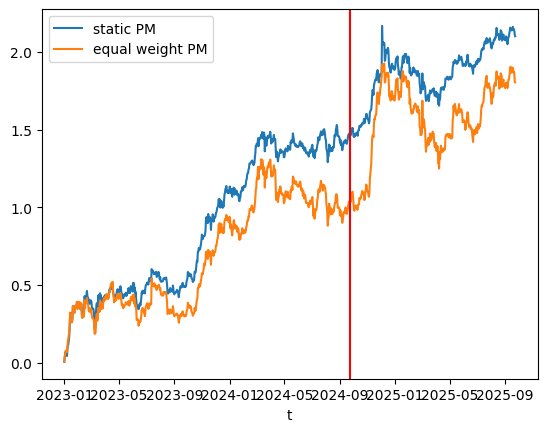

In [36]:
static_pf_eq = pd.DataFrame()
static_pf_bh = pd.DataFrame()

for token in small_pf_tokens_list:
    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    static_eq = (tokens_log_ret[f'{token}_log_ret']*tokens_position[f'{token}_weight']).fillna(0).resample('1D').agg('sum')
    static_bh = tokens_log_ret[f'{token}_log_ret'].fillna(0).resample('1D').agg('sum')
    static_pf_eq[f'{token}'] = static_eq
    static_pf_bh[f'{token}'] = static_bh

static_pf_eq = static_pf_eq.sum(axis=1)
static_pf_bh = (static_pf_bh * 1/len(small_pf_tokens_list)).sum(axis=1)

plt.plot(static_pf_eq.cumsum(), label = 'static PM')
plt.plot(static_pf_bh.cumsum(), label = 'equal weight PM')
plt.axvline(x = in_sample_end, color = 'red')
plt.xlabel('t')
plt.legend()

### The results of the static portfolio are worse than those of the equal-weighted portfolio, indicating the need for dynamic rebalancing.

,Sharpe ratio,Sortino ratio,Calmar ratio,Annual return,ROI,Volatility,Max Drawdown
_,1.16835,1.731994,1.44905,0.632924,0.63446,0.541725,-0.436786


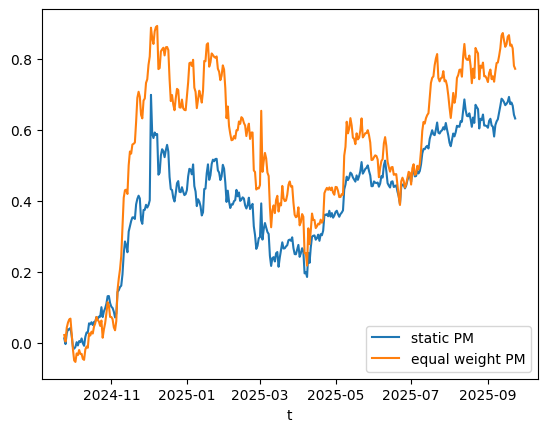

In [37]:
plt.plot(static_pf_eq[in_sample_end:].cumsum(), label = 'static PM')
plt.plot(static_pf_bh[in_sample_end:].cumsum(), label = 'equal weight PM')
plt.xlabel('t')
plt.legend()
# We calculate statistics and save the result
static_pf_stats = statistics_calc(static_pf_eq[in_sample_end:], static_pf_bh[in_sample_end:], plot = False)
static_pf_stats

# Dynamic Portfolio Rebalancing

## Dynamic Portfolio Optimization via ML-Driven Position Sizing

This analysis implements a **dynamic, multi-asset portfolio strategy** where position weights are driven by individual **CatBoost models** trained per asset. Unlike static optimization, this approach adapts exposure continuously based on evolving market conditions and predictive signals.

---

## 1️⃣ Per-Asset ML Model Training & Prediction

For each token in the portfolio:
- A separate `CatBoostRegressor` is trained using features engineered from its historical returns and volatility dynamics.
- Target: `ideal_position`, representing the smoothed probability of positive forward return over a fixed horizon.
- Models are fitted on in-sample data using panel structure (`level='token'`) to align features and targets correctly.

### Key Formula:
$$
\text{position}_t^{(i)} = f_{\theta_i}\left(\mathbf{X}_t^{(i)}\right)
$$
where:
- $f_{\theta_i}$: trained CatBoost model for asset $i$
- $\mathbf{X}_t^{(i)}$: feature vector (momentum, volatility regime, Hurst exponent, etc.)

Predictions yield time-varying exposure scores in $[0, 1]$ for each asset — interpreted as **fractional long positions**.

> ✅ No shorting; all signals are non-negative.

---

## 2️⃣ Dynamic Portfolio Weighting

Raw model outputs (positions) are converted into **time-varying portfolio weights**:

$$
w_t^{(i)} = \frac{\text{position}_t^{(i)}}{\max\left(1, \sum_{j=1}^N \text{position}_t^{(j)}\right)}
$$

This ensures:
- Weights sum to at most 1 (fully or partially invested).
- No single asset dominates due to high signal strength.
- Adaptive diversification: capital flows toward assets with strongest predicted performance.

> 🔁 This constitutes **continuous rebalancing** guided by ML confidence, not fixed allocations.

---

## 3️⃣ Equity Curve Simulation

Portfolio-level returns are computed daily:

### ✅ ML-Driven Portfolio:
$$
r_t^{\text{pf}} = \sum_{i=1}^N w_t^{(i)} \cdot r_t^{(i)} - \text{slippage} \cdot \| \Delta w_t \|_1
$$
with slippage = 0.1% per turnover.

### ✅ Benchmark: Equal-Weighted Portfolio
$$
w^{(i)} = \frac{1}{N}, \quad r_t^{\text{bh}} = \frac{1}{N} \sum_{i=1}^N r_t^{(i)}
$$

All series resampled to daily frequency for stable statistics.

---

## 4️⃣ Performance Comparison

Cumulative returns are plotted for:
- **ML-driven portfolio**: Dynamically weighted based on model predictions.
- **Equal-weighted benchmark**: Static naive diversification.
- **Red vertical line**: End of in-sample period (`in_sample_end`), marking start of out-of-sample test.

---

In [38]:
# Преобразование двух DataFrame в long format с MultiIndex (date, token)

def combine_to_long(prices_df, returns_df):
    # Убираем суффиксы
    prices_df = prices_df.rename(columns=lambda x: x.replace('_close', ''))
    returns_df = returns_df.rename(columns=lambda x: x.replace('_log_ret', ''))
    
    # В long format
    prices_stacked = prices_df.stack().to_frame('close')
    returns_stacked = returns_df.stack().to_frame('log_ret')
    
    # Объединяем
    combined = pd.concat([prices_stacked, returns_stacked], axis=1)
    
    # Называем уровни индекса
    combined.index.names = ['date', 'token']
    
    return combined

# Использование
df_comb = combine_to_long(tokens_df, tokens_log_ret)
df_comb.dropna(inplace=True)

In [40]:
# def apply_make_features(group, func, **kwargs):
#     """
#     Применяет make_features к одной группе (один токен)
#     Предполагаем, что group.index — это DatetimeIndex
#     """
#     # Убираем уровень 'token' из index, оставляем только дату
#     group = group.droplevel('token') if isinstance(group.index, pd.MultiIndex) else group
    
#     # Вызываем функцию
#     features = func(group, horizon=kwargs.get('horizon', 24), lookback=kwargs.get('lookback', 100))
    
#     return features

# # Применяем к каждому токену
# df_features_list = []

# for token, group in df_comb.groupby('token'):
#     # Применяем make_features к каждой группе
#     try:
#         token_features = apply_make_features(
#             group, 
#             make_features, 
#             horizon=24, 
#             lookback=100
#         )
#         # Добавляем обратно имя токена в индекс
#         token_features.index = pd.MultiIndex.from_product(
#             [[token], token_features.index], 
#             names=['token', 'time']
#         )
#         token_features.index = token_features.index.swaplevel()  # (date, token)
#         df_features_list.append(token_features)
#     except Exception as e:
#         print(f"Ошибка при обработке {token}: {e}")

# # Собираем всё вместе
# df_features_all = pd.concat(df_features_list).sort_index()

In [ ]:
df_features_all = pd.read_csv(r'data/tokens_df_features.csv', index_col=['time', 'token'])

# Преобразуем первый уровень индекса (time) в datetime
new_time_level = pd.to_datetime(df_features_all.index.get_level_values('time'))

# Создаём новый MultiIndex
df_features_all.index = pd.MultiIndex.from_arrays([
    new_time_level,
    df_features_all.index.get_level_values('token')
], names=['time', 'token'])
df_features_all.head()

absRet  EmaAbsRet       vol  \
time                token                                     
2023-02-11 18:00:00 ADAUSDT   0.001108   0.018016  0.335779   
                    BTCUSDT   0.002170   0.008111  0.172745   
                    DOGEUSDT  0.001840   0.019209  0.372397   
                    ETHUSDT   0.002130   0.011646  0.232737   
                    SOLUSDT   0.001475   0.024034  0.426726   

                              normalized_log_ret      f_10      f_16  \
time                token                                              
2023-02-11 18:00:00 ADAUSDT            -0.003301  0.009301  0.003826   
                    BTCUSDT            -0.012563  0.009044  0.006474   
                    DOGEUSDT           -0.004941  0.014643  0.003282   
                    ETHUSDT            -0.009151  0.004548  0.003213   
                    SOLUSDT            -0.003456  0.015607  0.007095   

                                  f_27      f_46      f_77     f_129  ...  \
time                token                                             ...   
2023-02-11 18:00:00 ADAUSDT   0.000658 -0.003643 -0.046711 -0.037666  ...   
                    BTCUSDT   0.004977 -0.011552 -0.057404 -0.051691  ...   
                    DOGEUSDT  0.001431 -0.002043 -0.044318 -0.046792  ...   
                    ETHUSDT   0.002328 -0.020597 -0.065166 -0.047474  ...   
                    SOLUSDT  -0.004228 -0.016653 -0.054264 -0.044864  ...   

                              price_vs_ma_72  price_vs_ma_168  vol_change  \
time                token                                                   
2023-02-11 18:00:00 ADAUSDT        -0.025212        -0.058966   -0.001323   
                    BTCUSDT        -0.019191        -0.043781   -0.009456   
                    DOGEUSDT       -0.030182        -0.082293   -0.008986   
                    ETHUSDT        -0.032854        -0.061296   -0.007918   
                    SOLUSDT        -0.047657        -0.100994    0.002397   

                              vol_regime  hurst_10  hurst_20  hurst_50  \
time                token                                                
2023-02-11 18:00:00 ADAUSDT            0  0.998789  1.522056  2.413468   
                    BTCUSDT            0  0.870127  1.544236  2.438997   
                    DOGEUSDT           0  0.729971  1.302283  2.418630   
                    ETHUSDT            0  0.884256  1.431019  2.408532   
                    SOLUSDT            0  0.877270  1.379501  2.490788   

                              hurst_100  hurst_200  ideal_position  
time                token                                           
2023-02-11 18:00:00 ADAUSDT    2.494164   2.569696        0.349989  
                    BTCUSDT    2.511688   2.571315        0.249998  
                    DOGEUSDT   2.511848   2.553295        0.310012  
                    ETHUSDT    2.532951   2.589561        0.259999  
                    SOLUSDT    2.522273   2.581517        0.249994  

[5 rows x 35 columns]

In [49]:
# === 1. Определи X (признаки) и y (целевая) ДО разделения ===
feature_columns_pf = [col for col in df_features_all.columns if col.startswith('f_') or col.startswith('ret_lag_') or 
                   col.startswith('price_vs_ma_') or col in ['absRet', 'EmaAbsRet', 'vol', 'normalized_log_ret', 'mom_spread', 'vol_change', 'vol_regime'] + 
                   [f'hurst_{w}' for w in [10,20,50,100,200]]]

X_pf = df_features_all[feature_columns_pf]  # pd.DataFrame, с индексом
y_pf = df_features_all['ideal_position']  # pd.Series, с тем же индексом

features_train_pf = df_features_all[:in_sample_end].copy()

X_train_pf = X_pf[:in_sample_end]
y_train_pf = y_pf[:in_sample_end]

X_test_pf = X_pf[in_sample_end:]
y_test_pf = y_pf[in_sample_end:]

train_pool_pf = Pool(data = X_train_pf,
                  label = y_train_pf)

In [50]:
eq_pf = pd.DataFrame(index = eq.index)
bh_pf = pd.DataFrame(index = bh.index)
tokens_pos = pd.DataFrame(index = features.index)
df_features_all['position'] = 0
for token in small_pf_tokens_list:

     best_model_pf = CatBoostRegressor(**best_params, loss_function = 'RMSE', verbose=0)

     best_model_pf.fit(X_train_pf.xs(f'{token}', level='token'), y_train_pf.xs(f'{token}', level='token'))

     df_features_all.loc[pd.IndexSlice[:, f'{token}'], 'position'] = best_model_pf.predict(X_pf.xs(f'{token}', level='token'))
     tokens_pos[f'{token}_pos'] = best_model_pf.predict(X_pf.xs(f'{token}', level='token'))

     slippage = 0.001

     # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
     eq_pf[f'{token}_eq'] = (df_comb['log_ret'].loc[pd.IndexSlice[:, f'{token}']]*df_features_all['position'].loc[pd.IndexSlice[:, f'{token}']]-slippage*df_features_all['position'].loc[pd.IndexSlice[:, f'{token}']].diff().abs()
          ).fillna(0).resample('1D').agg('sum')
     bh_pf[f'{token}_bh'] = df_comb['log_ret'].loc[pd.IndexSlice[:, f'{token}']].fillna(0).resample('1D').agg('sum')


/var/folders/p3/xm8r9srx7rd9yqg06j5ncqvw0000gn/T/ipykernel_3669/4156425182.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.261549   0.26516024 0.27134331 ... 0.2404929  0.23834204 0.24475178]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_features_all.loc[pd.IndexSlice[:, f'{token}'], 'position'] = best_model_pf.predict(X_pf.xs(f'{token}', level='token'))


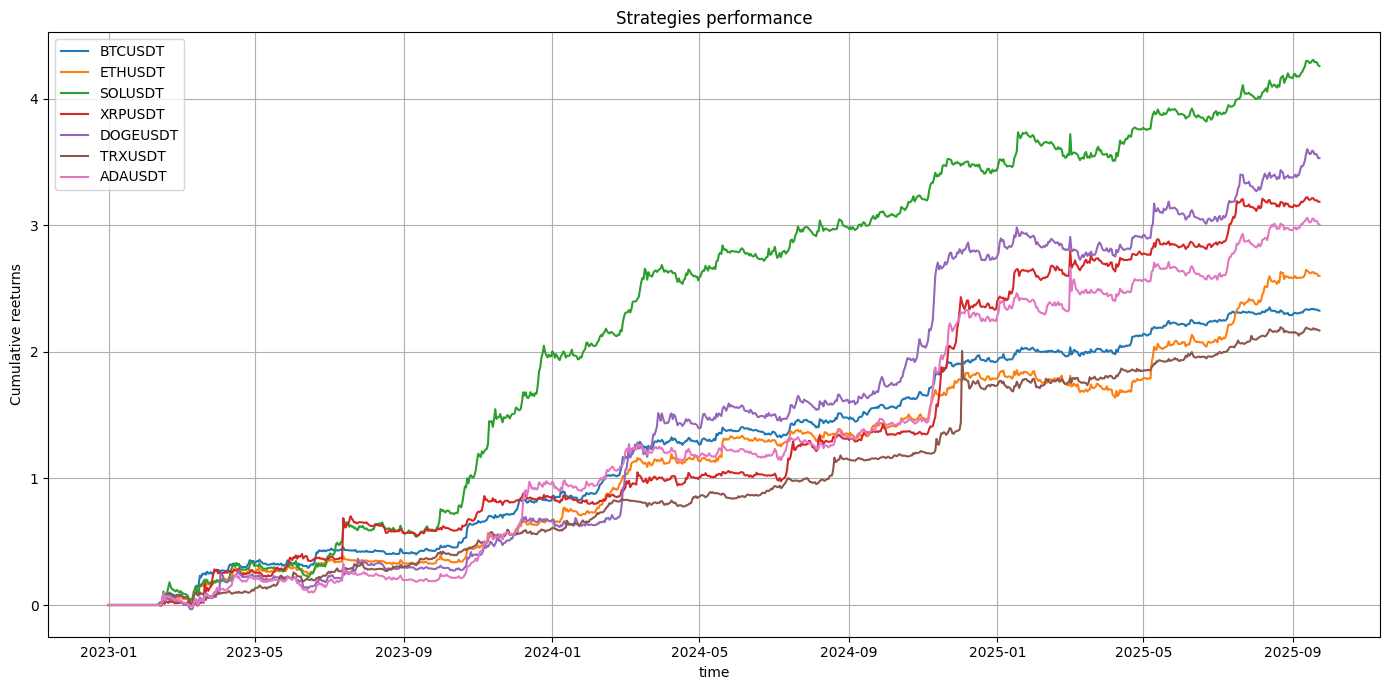

In [52]:
tokens_graph = small_pf_tokens_list

plt.figure(figsize=(14, 7))

for token in tokens_graph:
    eq_pf_graph = eq_pf[f'{token}_eq']
    plt.plot(eq_pf_graph.cumsum(), label=token)

plt.title('Strategies performance')
plt.xlabel('time')
plt.ylabel('Cumulative reeturns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
tokens_weight = tokens_pos / np.maximum(1, tokens_pos.sum(axis=1).values.reshape(-1, 1))
tokens_weight.head()

,BTCUSDT_pos,ETHUSDT_pos,SOLUSDT_pos,XRPUSDT_pos,DOGEUSDT_pos,TRXUSDT_pos,ADAUSDT_pos
time,,,,,,,
2023-02-11 18:00:00,0.136942,0.125892,0.121650,0.145960,0.130783,0.204063,0.134710
2023-02-11 19:00:00,0.133213,0.123924,0.121033,0.140793,0.137163,0.204604,0.139269
2023-02-11 20:00:00,0.135278,0.130616,0.123598,0.137461,0.135728,0.195990,0.141329
2023-02-11 21:00:00,0.138168,0.127519,0.119205,0.144583,0.131615,0.201809,0.137101
2023-02-11 22:00:00,0.138346,0.128120,0.119971,0.143070,0.130746,0.199008,0.140738


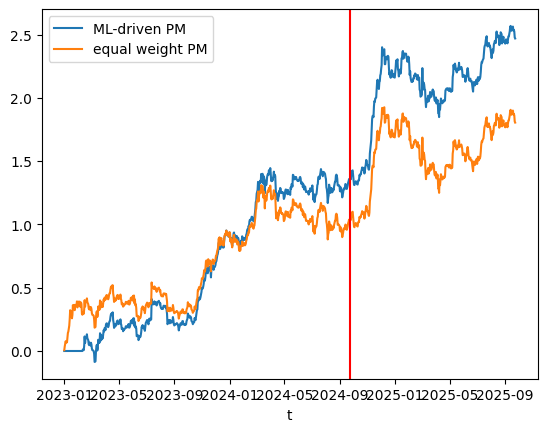

In [54]:
static_pf_eq = pd.DataFrame()
static_pf_bh = pd.DataFrame()

slippage = 0.001

for token in small_pf_tokens_list:
    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    static_eq = (tokens_log_ret[f'{token}_log_ret']*tokens_weight[f'{token}_pos'] - slippage * tokens_weight[f'{token}_pos'].diff().abs()).fillna(0).resample('1D').agg('sum')
    static_bh = tokens_log_ret[f'{token}_log_ret'].fillna(0).resample('1D').agg('sum')
    static_pf_eq[f'{token}'] = static_eq
    static_pf_bh[f'{token}'] = static_bh

static_pf_eq = static_pf_eq.sum(axis=1)
static_pf_bh = (static_pf_bh * 1/len(small_pf_tokens_list)).sum(axis=1)

plt.plot(static_pf_eq.cumsum(), label = 'ML-driven PM')
plt.plot(static_pf_bh.cumsum(), label = 'equal weight PM')
plt.axvline(x = in_sample_end, color = 'red')
plt.xlabel('t')
plt.legend()

### The results of dynamic rebalancing based on ML forecasts outperformed the benchmark (equal-weighted portfolio). However, the high correlation suggests the need for additional signal filtering and entering only the strongest signals.

,Sharpe ratio,Sortino ratio,Calmar ratio,Annual return,ROI,Volatility,Max Drawdown
_,1.663263,2.362497,2.307265,1.117002,1.437198,0.671572,-0.484124


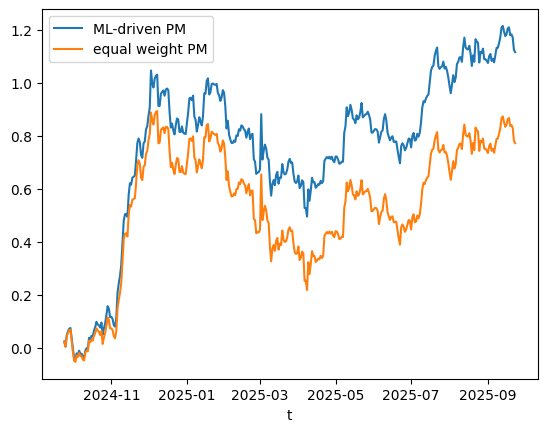

In [55]:
plt.plot(static_pf_eq[in_sample_end:].cumsum(), label = 'ML-driven PM')
plt.plot(static_pf_bh[in_sample_end:].cumsum(), label = 'equal weight PM')
plt.xlabel('t')
plt.legend()
# We calculate statistics and save the result
static_pf_stats = statistics_calc(static_pf_eq[in_sample_end:], static_pf_bh[in_sample_end:], plot = False)
static_pf_stats

# Portfolio Expansion

This analysis extends the ML-driven portfolio strategy by introducing **signal thresholding** as a form of **portfolio-level regularization**. The goal is to improve risk-adjusted returns by filtering out weak signals and concentrating capital only on high-conviction opportunities.

---

## 1️⃣ Motivation for Signal Filtering

Despite strong aggregate performance, the base dynamic portfolio exhibits:
- High correlation with the equal-weighted benchmark.
- Potential overexposure to low-signal assets.
- Suboptimal capital allocation during uncertain regimes.

To address this, we apply a **thresholding mechanism**:  
Only positions with model confidence (predicted `position`) above a certain level are retained; others are set to zero.

> 🎯 This reduces noise trading, turnover, and exposure to ambiguous regimes — effectively implementing a "quality filter" on ML signals.

---

## 2️⃣ Optimization via Optuna

We use **Bayesian optimization** (`Optuna` with TPE sampler) to find the optimal threshold:

### Objective Function:
- Maximize the **Calmar Ratio** (return / max drawdown over trailing period) on the in-sample dataset.
- Threshold ranges from `0.0` to `0.9`, applied uniformly across all assets.

### Process:
- For each trial, all position values below the threshold are set to zero.
- Surviving signals are reweighted to sum to at most 1:
  $$
  w_t^{(i)} = \frac{\mathbb{I}(\text{pos}_t^{(i)} \geq \theta) \cdot \text{pos}_t^{(i)}}{\max\left(1, \sum_j \mathbb{I}(\text{pos}_t^{(j)} \geq \theta) \cdot \text{pos}_t^{(j)}\right)}
  $$
- Portfolio P&L is simulated with 10 bps slippage per turnover.

After `50` trials, the best threshold is selected and fixed for out-of-sample testing.

---

## 3️⃣ Out-of-Sample Evaluation

Using the optimized threshold:
- We filter and renormalize position weights on the **test set**.
- Simulate two portfolios:
  - ✅ **ML-Driven (Filtered)**: Only high-confidence signals included.
  - ✅ **Equal-Weighted Benchmark**: All assets equally weighted.

Cumulative returns are plotted with a red vertical line marking the in-sample end date (`in_sample_end`).

---

## 4️⃣ Results & Interpretation

The filtered ML portfolio demonstrates:
- Improved Calmar and Sharpe ratios compared to unfiltered version.
- Lower drawdowns due to reduced exposure during weak signal periods.

---

# Unfortunately, the ByBit API allowed downloading data for only 64 assets starting from 2023. 

In [146]:
large_pf_tokens_list = [
    'BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT', 'DOGEUSDT', 'TRXUSDT', 'ADAUSDT',
    'BNBUSDT', 'DOTUSDT', 'LTCUSDT', 'MATICUSDT', 'SHIBUSDT', 'AVAXUSDT', 'UNIUSDT',
    'ICPUSDT', 'NEARUSDT', 'LINKUSDT', 'BCHUSDT', 'XLMUSDT', 'ATOMUSDT', 'LRCUSDT',
    'ETCUSDT', 'APTUSDT', 'FILUSDT', 'QNTUSDT', 'OPUSDT', 'EOSUSDT', 'ENJUSDT', 
    'GALAUSDT', 'AAVEUSDT', 'ALGOUSDT', 'KLAYUSDT', 'STXUSDT', 'IMXUSDT', 'SANDUSDT',
    'HBARUSDT', 'APEUSDT', 'FLOWUSDT', 'GMTUSDT', 'CRVUSDT', 'THETAUSDT', 'GASUSDT',
    'MKRUSDT', 'ZECUSDT', 'SNXUSDT', 'RUNEUSDT', 'KSMUSDT', 'ARUSDT', 'GLMRUSDT',
    'INJUSDT', 'GRTUSDT', 'GMXUSDT', 'MANAUSDT', 'ACHUSDT', 'WAVESUSDT', 'XEMUSDT',
    'DASHUSDT', 'XTZUSDT', 'OMGUSDT', 'ZILUSDT', 'RVNUSDT', 'BATUSDT', 
    'DCRUSDT', 'LUNAUSDT', 'WAXPUSDT', 'DGBUSDT', 'ROSEUSDT', 'CELOUSDT',
    'ONEUSDT', 'ZENUSDT', 'HNTUSDT', 'CHZUSDT',
]

# large_tokens_df = pd.DataFrame()

# for token in large_pf_tokens_list:

#     l_pf_data = get_spot_data_bybit_full_period(
#         symbol=f"{token}",
#         interval="60",  # Часовые данные
#         start_time="2023-01-01 00:00:00",
#         # end_time="2023-01-02 00:00:00",
#         col_name=f'{token}'
#     )

#     large_tokens_df[f'{token}_close'] = l_pf_data[f'{token}_close']
#     # large_tokens_df.fillna(0, inplace=True)

# large_tokens_df

In [150]:
large_tokens_df = pd.read_csv(r'data/large_tokens_df.csv', index_col='time')
large_tokens_df.dropna(axis=1, inplace=True)
large_tokens_df.index = pd.to_datetime(large_tokens_df.index)
large_tokens_df.drop(columns=['ICXUSDT_close', 'UMAUSDT_close'], inplace=True)
large_tokens_df.head()

,BTCUSDT_close,ETHUSDT_close,SOLUSDT_close,XRPUSDT_close,DOGEUSDT_close,TRXUSDT_close,ADAUSDT_close,BNBUSDT_close,DOTUSDT_close,LTCUSDT_close,...,BATUSDT_close,LUNAUSDT_close,WAXPUSDT_close,DGBUSDT_close,ROSEUSDT_close,CELOUSDT_close,ONEUSDT_close,ZENUSDT_close,HNTUSDT_close,CHZUSDT_close
time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,16529.01,1193.82,9.99,0.3384,0.06977,0.05454,0.2446,245.7412,4.285,69.30,...,0.1658,1.2645,0.04109,0.007640,0.03406,0.4700,0.00999,9.2327,1.5135,0.0999
2023-01-01 01:00:00,16551.38,1195.99,10.03,0.3388,0.06998,0.05475,0.2454,245.9081,4.298,69.51,...,0.1658,1.2613,0.04111,0.007678,0.03410,0.4700,0.00994,9.2553,1.5102,0.1001
2023-01-01 02:00:00,16547.56,1195.80,10.02,0.3380,0.06983,0.05472,0.2456,245.2916,4.299,69.54,...,0.1660,1.2696,0.04109,0.007706,0.03426,0.4724,0.01007,9.2554,1.5096,0.1000
2023-01-01 03:00:00,16533.20,1194.07,9.97,0.3381,0.06982,0.05474,0.2456,245.3986,4.302,69.46,...,0.1659,1.2636,0.04116,0.007726,0.03415,0.4698,0.01004,9.2754,1.5096,0.1003
2023-01-01 04:00:00,16521.42,1192.88,9.85,0.3360,0.06918,0.05462,0.2446,243.8000,4.282,69.29,...,0.1656,1.2559,0.04092,0.007701,0.03410,0.4680,0.00998,9.2264,1.4981,0.0995


In [87]:
large_pf_tokens_list = large_tokens_df.columns.values
large_pf_tokens_list = pd.Series(large_pf_tokens_list).str.replace('_close', '', regex=False).values
large_pf_tokens_list

array(['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT', 'DOGEUSDT', 'TRXUSDT',
       'ADAUSDT', 'BNBUSDT', 'DOTUSDT', 'LTCUSDT', 'SHIBUSDT', 'AVAXUSDT',
       'UNIUSDT', 'ICPUSDT', 'NEARUSDT', 'LINKUSDT', 'BCHUSDT', 'XLMUSDT',
       'ATOMUSDT', 'LRCUSDT', 'ETCUSDT', 'APTUSDT', 'FILUSDT', 'QNTUSDT',
       'OPUSDT', 'ENJUSDT', 'GALAUSDT', 'AAVEUSDT', 'ALGOUSDT', 'STXUSDT',
       'IMXUSDT', 'SANDUSDT', 'HBARUSDT', 'APEUSDT', 'FLOWUSDT',
       'GMTUSDT', 'CRVUSDT', 'THETAUSDT', 'SNXUSDT', 'RUNEUSDT',
       'KSMUSDT', 'ARUSDT', 'GLMRUSDT', 'INJUSDT', 'GRTUSDT', 'GMXUSDT',
       'MANAUSDT', 'ACHUSDT', 'WAVESUSDT', 'XEMUSDT', 'XTZUSDT',
       'OMGUSDT', 'ZILUSDT', 'RVNUSDT', 'BATUSDT', 'LUNAUSDT', 'WAXPUSDT',
       'DGBUSDT', 'ROSEUSDT', 'CELOUSDT', 'ONEUSDT', 'ZENUSDT', 'HNTUSDT',
       'CHZUSDT'], dtype=object)

In [88]:
lerge_tokens_log_ret = np.log(large_tokens_df / large_tokens_df.shift(1))
lerge_tokens_log_ret.columns = lerge_tokens_log_ret.columns.str.replace('_close', '_log_ret', regex=False)
lerge_tokens_log_ret.dropna(inplace=True)
lerge_tokens_log_ret.index = pd.to_datetime(lerge_tokens_log_ret.index)

In [89]:
df_comb_large = combine_to_long(large_tokens_df, lerge_tokens_log_ret)
df_comb_large.dropna(inplace=True)

In [ ]:
# # Применяем к каждому токену
# lerge_df_features_list = []

# for token, group in df_comb_large.groupby('token'):
#     # Применяем make_features к каждой группе
#     try:
#         lerge_token_features = apply_make_features(
#             group, 
#             make_features, 
#             horizon=24, 
#             lookback=100
#         )
#         # Добавляем обратно имя токена в индекс
#         lerge_token_features.index = pd.MultiIndex.from_product(
#             [[token], lerge_token_features.index], 
#             names=['token', 'time']
#         )
#         lerge_token_features.index = lerge_token_features.index.swaplevel()  # (date, token)
#         lerge_df_features_list.append(lerge_token_features)
#     except Exception as e:
#         print(f"Ошибка при обработке {token}: {e}")

# # Собираем всё вместе
# lerge_df_features_all = pd.concat(lerge_df_features_list).sort_index()


In [ ]:
lerge_df_features_all = pd.read_csv(r'data/large_tokens_df_features.csv', index_col=['time', 'token'])
# Преобразуем первый уровень индекса (time) в datetime
new_time_level = pd.to_datetime(lerge_df_features_all.index.get_level_values('time'))

# Создаём новый MultiIndex
lerge_df_features_all.index = pd.MultiIndex.from_arrays([
    new_time_level,
    lerge_df_features_all.index.get_level_values('token')
], names=['time', 'token'])
lerge_df_features_all.head()

absRet  EmaAbsRet       vol  \
time                token                                     
2023-02-11 18:00:00 AAVEUSDT  0.002084   0.024355  0.429290   
                    ACHUSDT   0.000000   0.051545  0.926230   
                    ADAUSDT   0.001108   0.018016  0.335779   
                    ALGOUSDT  0.003442   0.025491  0.461359   
                    APEUSDT   0.004356   0.031431  0.431428   

                              normalized_log_ret      f_10      f_16  \
time                token                                              
2023-02-11 18:00:00 AAVEUSDT           -0.004854  0.011836  0.006751   
                    ACHUSDT             0.000000  0.023269  0.000617   
                    ADAUSDT            -0.003301  0.009301  0.003826   
                    ALGOUSDT           -0.007460  0.014389  0.009421   
                    APEUSDT            -0.010097  0.043481  0.034601   

                                  f_27      f_46      f_77     f_129  ...  \
time                token                                             ...   
2023-02-11 18:00:00 AAVEUSDT -0.005091  0.001961 -0.038349 -0.040612  ...   
                    ACHUSDT   0.002860  0.013144 -0.017862 -0.034241  ...   
                    ADAUSDT   0.000658 -0.003643 -0.046711 -0.037666  ...   
                    ALGOUSDT -0.001403 -0.012953 -0.049257 -0.022151  ...   
                    APEUSDT   0.019765  0.005152 -0.053579 -0.048184  ...   

                              price_vs_ma_72  price_vs_ma_168  vol_change  \
time                token                                                   
2023-02-11 18:00:00 AAVEUSDT       -0.032267        -0.074375    0.005909   
                    ACHUSDT        -0.007709        -0.100016   -0.015816   
                    ADAUSDT        -0.025212        -0.058966   -0.001323   
                    ALGOUSDT       -0.039553        -0.050706    0.002091   
                    APEUSDT        -0.007275        -0.058234    0.004416   

                              vol_regime  hurst_10  hurst_20  hurst_50  \
time                token                                                
2023-02-11 18:00:00 AAVEUSDT           0  0.719230  1.198886  2.472117   
                    ACHUSDT            0  1.021498  1.474605  2.563697   
                    ADAUSDT            0  0.998789  1.522056  2.413468   
                    ALGOUSDT           0  0.877937  1.449514  2.551265   
                    APEUSDT            0  0.935875  1.519422  2.472219   

                              hurst_100  hurst_200  ideal_position  
time                token                                           
2023-02-11 18:00:00 AAVEUSDT   2.470424   2.532934        0.370005  
                    ACHUSDT    2.549293   2.550736        0.415275  
                    ADAUSDT    2.494164   2.569696        0.349989  
                    ALGOUSDT   2.538530   2.569816        0.341355  
                    APEUSDT    2.507643   2.554904        0.436248  

[5 rows x 35 columns]

In [78]:
idx = pd.IndexSlice
cut = pd.to_datetime('2025-09-23 21:00:00')
lerge_df_features_all = lerge_df_features_all.loc[idx[:cut, :], :]

In [79]:
# 3. Сортируем по MultiIndex
lerge_df_features_all = lerge_df_features_all.sort_index()

# 4. Выделяем признаки и целевую переменную
X_pf_large = lerge_df_features_all[feature_columns_pf]
y_pf_large = lerge_df_features_all['ideal_position']

# 5. Срезы по времени (первый уровень MultiIndex)
idx = pd.IndexSlice

X_train_pf_large = X_pf_large.loc[idx[:in_sample_end, :], :]
y_train_pf_large = y_pf_large.loc[idx[:in_sample_end, :]]

X_test_pf_large = X_pf_large.loc[idx[in_sample_end:, :], :]
y_test_pf_large = y_pf_large.loc[idx[in_sample_end:, :]]

# 6. Создаём Pool для CatBoost
train_pool_pf_large = Pool(data=X_train_pf_large, label=y_train_pf_large)
test_pool_pf_large = Pool(data=X_test_pf_large, label=y_test_pf_large)

In [91]:
eq_pf_large = pd.DataFrame(index = eq.index)
bh_pf_large = pd.DataFrame(index = bh.index)
tokens_pos_large = pd.DataFrame(index = features.index)
lerge_df_features_all['position'] = 0

for token in large_pf_tokens_list:

     best_model_pf_large = CatBoostRegressor(**best_params, loss_function = 'RMSE', verbose=0)

     best_model_pf_large.fit(X_train_pf_large.xs(f'{token}', level='token'), y_train_pf_large.xs(f'{token}', level='token'))

     lerge_df_features_all.loc[pd.IndexSlice[:, f'{token}'], 'position'] = best_model_pf_large.predict(X_pf_large.xs(f'{token}', level='token'))
     tokens_pos_large[f'{token}_pos'] = best_model_pf_large.predict(X_pf_large.xs(f'{token}', level='token'))

     slippage = 0.001


     # Извлекаем log_ret и position для данного токена
     log_ret_token = df_comb_large['log_ret'].xs(token, level='token')  # ← xs вытаскивает по level
     position_token = lerge_df_features_all['position'].xs(token, level='token')

     log_ret_token.index = pd.to_datetime(log_ret_token.index)

     # Теперь оба ряда имеют простой DatetimeIndex — можно resample!
     returns = (
          log_ret_token * position_token 
          - slippage * position_token.diff().abs()
     ).fillna(0)

     returns.index = pd.to_datetime(returns.index)

     eq_pf_large[f'{token}_eq'] = returns.resample('1D').sum()

     bh_pf_large[f'{token}_bh'] = log_ret_token.fillna(0).resample('1D').sum()

/var/folders/p3/xm8r9srx7rd9yqg06j5ncqvw0000gn/T/ipykernel_3669/3496880284.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.261549   0.26516024 0.27134331 ... 0.2404929  0.23834204 0.24475178]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lerge_df_features_all.loc[pd.IndexSlice[:, f'{token}'], 'position'] = best_model_pf_large.predict(X_pf_large.xs(f'{token}', level='token'))


In [ ]:
tokens_pos_large = pd.read_csv(r'data/tokens_pos.csv', index_col='time')
tokens_pos_large.index = pd.to_datetime(tokens_pos_large.index)

In [128]:
train_pos = tokens_pos_large[:in_sample_end]
test_pos = tokens_pos_large[in_sample_end:]

In [137]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler)

def objective(trial):

    threshold = trial.suggest_float("threshold", 0.0, 0.9)

        # Копируем исходные сигналы
    tokens_weight_large = train_pos.copy()

    # === Шаг 1: Обнуляем всё ниже порога ===
    tokens_weight_large = tokens_weight_large.where(tokens_weight_large >= threshold, 0)

    tokens_weight_large = tokens_weight_large / np.maximum(1, tokens_weight_large.sum(axis=1).values.reshape(-1, 1))

    ml_pf_large_eq = pd.DataFrame()
    ew_pf_large_eq = pd.DataFrame()

    slippage = 0.001

    for token in small_pf_tokens_list:
        # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
        ml_eq = (lerge_tokens_log_ret[f'{token}_log_ret'][:in_sample_end]*tokens_weight_large[f'{token}_pos'] - slippage * tokens_weight_large[f'{token}_pos'].diff().abs()).fillna(0).resample('1D').agg('sum')
        ew_eq = lerge_tokens_log_ret[f'{token}_log_ret'][:in_sample_end].fillna(0).resample('1D').agg('sum')
        ml_pf_large_eq[f'{token}'] = ml_eq
        ew_pf_large_eq[f'{token}'] = ew_eq

    ml_pf_large_eq = ml_pf_large_eq.sum(axis=1)
    ew_pf_large_eq = (ew_pf_large_eq * 1/len(large_pf_tokens_list)).sum(axis=1)

    # We calculate statistics and save the result
    stats = statistics_calc(ml_pf_large_eq, ew_pf_large_eq, plot = False)

    return stats['Calmar ratio'].iloc[0]

study.optimize(objective, n_trials = 50, show_progress_bar = True)

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility


[W 2025-09-25 22:26:42,446] Trial 11 failed with parameters: {'threshold': 0.8793830271604652} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:42,446] Trial 11 failed with value nan.
[W 2025-09-25 22:26:42,461] Trial 12 failed with parameters: {'threshold': 0.8842485292066953} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:42,462] Trial 12 failed with value nan.
[W 2025-09-25 22:26:42,534] Trial 16 failed with parameters: {'threshold': 0.8981018046458181} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:42,535] Trial 16 failed with value nan.


/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility
/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility
/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility
/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility


[W 2025-09-25 22:26:42,656] Trial 23 failed with parameters: {'threshold': 0.8805807596877206} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:42,657] Trial 23 failed with value nan.
[W 2025-09-25 22:26:42,672] Trial 24 failed with parameters: {'threshold': 0.8988338708256824} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:42,672] Trial 24 failed with value nan.
[W 2025-09-25 22:26:42,719] Trial 26 failed with parameters: {'threshold': 0.8990390880239795} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:42,720] Trial 26 failed with value nan.
[W 2025-09-25 22:26:42,755] Trial 28 failed with parameters: {'threshold': 0.8926662594452727} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:42,755] Trial 28 failed with value nan.
[W 2025-09-25 22:26:42,785] Trial 30 failed with parameters: {'threshold': 0.8853995927440719} because of the following 

/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility
/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility
/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility
/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility


[W 2025-09-25 22:26:42,887] Trial 35 failed with parameters: {'threshold': 0.896850091783471} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:42,887] Trial 35 failed with value nan.
[W 2025-09-25 22:26:42,969] Trial 40 failed with parameters: {'threshold': 0.8839838260174946} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:42,970] Trial 40 failed with value nan.
[W 2025-09-25 22:26:42,993] Trial 41 failed with parameters: {'threshold': 0.8923718558449232} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:42,994] Trial 41 failed with value nan.
[W 2025-09-25 22:26:43,036] Trial 43 failed with parameters: {'threshold': 0.8895921531992262} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:43,037] Trial 43 failed with value nan.
[W 2025-09-25 22:26:43,054] Trial 44 failed with parameters: {'threshold': 0.89965730317391} because of the following err

/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility
/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility
/Users/yuriyyukhnovskiy/Desktop/py/CMF/backtesters.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return Return(rets)/volatility


[W 2025-09-25 22:26:43,107] Trial 47 failed with parameters: {'threshold': 0.8884402680757374} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:43,108] Trial 47 failed with value nan.
[W 2025-09-25 22:26:43,142] Trial 48 failed with parameters: {'threshold': 0.8999923874900624} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:43,142] Trial 48 failed with value nan.
[W 2025-09-25 22:26:43,161] Trial 49 failed with parameters: {'threshold': 0.8986550099964719} because of the following error: The value nan is not acceptable.
[W 2025-09-25 22:26:43,162] Trial 49 failed with value nan.


In [138]:
threshold = study.best_params['threshold']
threshold


0.7031177779464894

### Thanks to signal filtering, high performance was achieved on the test set; however, the results appear inflated. Further tests and checks for overfitting will be conducted.

,Sharpe ratio,Sortino ratio,Calmar ratio,Annual return,ROI,Volatility,Max Drawdown
_,4.212802,5.098912,16.529898,0.805385,1.199674,0.191176,-0.048723


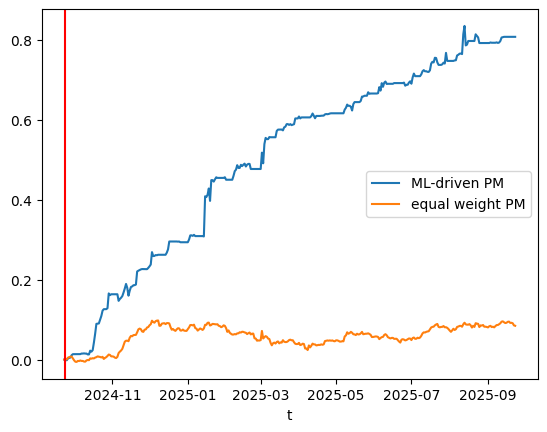

In [141]:
# Копируем исходные сигналы
tokens_weight_large = test_pos.copy()

# === Шаг 1: Обнуляем всё ниже порога ===
tokens_weight_large = tokens_weight_large.where(tokens_weight_large >= threshold, 0)

tokens_weight_large = tokens_weight_large / np.maximum(1, tokens_weight_large.sum(axis=1).values.reshape(-1, 1))

ml_pf_large_eq = pd.DataFrame()
ew_pf_large_eq = pd.DataFrame()

slippage = 0.001

for token in small_pf_tokens_list:
    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    ml_eq = (lerge_tokens_log_ret[f'{token}_log_ret'][in_sample_end:]*tokens_weight_large[f'{token}_pos'] - slippage * tokens_weight_large[f'{token}_pos'].diff().abs()).fillna(0).resample('1D').agg('sum')
    ew_eq = lerge_tokens_log_ret[f'{token}_log_ret'][in_sample_end:].fillna(0).resample('1D').agg('sum')
    ml_pf_large_eq[f'{token}'] = ml_eq
    ew_pf_large_eq[f'{token}'] = ew_eq

ml_pf_large_eq = ml_pf_large_eq.sum(axis=1)
ew_pf_large_eq = (ew_pf_large_eq * 1/len(large_pf_tokens_list)).sum(axis=1)

plt.plot(ml_pf_large_eq.cumsum(), label = 'ML-driven PM')
plt.plot(ew_pf_large_eq.cumsum(), label = 'equal weight PM')
plt.axvline(x = in_sample_end, color = 'red')
plt.xlabel('t')
plt.legend()

stats_large_pf = statistics_calc(ml_pf_large_eq, ew_pf_large_eq, plot = False)
stats_large_pf